# Importação de Bibliotecas

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV, StratifiedKFold, PredefinedSplit
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt
from sklearn import tree

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = pd.errors.SettingWithCopyWarning)

# Split Conjunto Treino/Teste

In [2]:
alvo = 'Churn'
df_tot = pd.read_csv('telco-customer-churn-real.zip', dtype = {'SeniorCitizen': str})
df_tot[alvo] = df_tot[alvo].map({'Yes': 1, 'No': 0})
df_tot.loc[df_tot['TotalCharges'] == ' ', 'TotalCharges'] = -1
df_tot['TotalCharges'] = df_tot['TotalCharges'].astype(float)

In [3]:
df_teste = df_tot.sample(frac = 0.5, random_state = 42)
df = df_tot[~df_tot.index.isin(df_teste.index)]

In [4]:
display(display(df_tot[['Partner', alvo]].groupby('Partner').agg(['count', 'mean'])))

Churn          
        count      mean
Partner                
No       1831  0.320590
Yes      1690  0.198817

None

# Tratamento de Features

In [5]:
colunas_id = ['customerID']
features_categoricas = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling',
                        'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                        'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
features_numericas = ['tenure', 'MonthlyCharges', 'TotalCharges']

In [6]:
dict_dummies = {'Partner': ['No']}
for f in [v for v in features_categoricas if v != 'Partner']:
    lista_dummies = list(df[f].value_counts().index[:-1])
    dict_dummies[f] = lista_dummies

for k,v in dict_dummies.items():
    for value in v:
        df[k + '_' + value] = (df[k] == value).astype(int)
        df_teste[k + '_' + value] = (df_teste[k] == value).astype(int)
    df.drop(k, axis = 1, inplace = True)
    df_teste.drop(k, axis = 1, inplace = True)
df.columns = [c.replace(' ', '_') for c in df.columns]
df_teste.columns = [c.replace(' ', '_') for c in df_teste.columns]

In [7]:
features = [v for v in df.columns if v not in colunas_id and v != alvo]

# Treinamento do Modelo

In [8]:
treinar_arvore = False
usar_teste_treinamento = False #Simula vazamento de informação

In [9]:
#Simula treinar com uma amostra da base
df_train = df.sample(frac = 1.0, random_state = 42)

In [10]:
X = df_train[features]
y = df_train[alvo].astype(int)

### Só Solteiros

In [11]:
mask = (df_train['Partner_No'] == 1).values
X_train = X[mask]
y_train = y[mask]

if treinar_arvore:
    clf = DecisionTreeClassifier(random_state = 42)
    param_grid = {
        "max_depth": [1],
    }
else:
    clf = LGBMClassifier(
                        objective = 'binary',
                        boosting_type = 'gbdt',
                        force_row_wise = True,
                        random_state = 42,
                        n_jobs = -1,
                        verbose = -1
                        )
    #Espaço de busca
    param_grid = {
        "n_estimators": [10, 20],
        "learning_rate": [0.03, 0.1],
        "max_depth": [2, 4, 6],
    }

if usar_teste_treinamento:
    mask_teste = (df_teste['Partner_No'] == 1).values
    X_concat = np.vstack([X_train, X_train, df_teste.loc[mask_teste, features]])
    y_concat = np.hstack([y_train, y_train, df_teste.loc[mask_teste, alvo]])
    test_fold = [-1]*len(X_train) + [0]*len(X_train) + [1]*len(df_teste[mask_teste])
    cv = PredefinedSplit(test_fold)
else:
    cv = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42)

#Métricas: usamos roc_auc como métrica principal para refit
grid = GridSearchCV(
        estimator = clf,
        param_grid = param_grid,
        scoring = {'roc_auc': 'roc_auc'},
        refit = 'roc_auc',
        cv = cv,
        n_jobs = -1,
        verbose = 1
    )

if usar_teste_treinamento:
    grid.fit(X_concat, y_concat)
else:
    grid.fit(X_train, y_train)

#Modelo final já vem refit com os melhores hiperparâmetros
best_model_solteiros = grid.best_estimator_

df_results = pd.DataFrame(grid.cv_results_)
if treinar_arvore:
    df_results = df_results[['param_max_depth', 'mean_test_roc_auc', 'std_test_roc_auc', 'rank_test_roc_auc']]
    plt.figure(figsize=(16,8))
    tree.plot_tree(best_model_solteiros,
                feature_names = features,
                filled = True,
                rounded = True)
    plt.show()
else:
    df_results = df_results[['param_learning_rate', 'param_max_depth', 'param_n_estimators', 'mean_test_roc_auc', 'std_test_roc_auc', 'rank_test_roc_auc']]
df_results = df_results.sort_values('rank_test_roc_auc')
display(df_results)

print("\n=== MELHORES PARÂMETROS (refit=roc_auc) ===")
print(grid.best_params_)

probs_solteiros = best_model_solteiros.predict_proba(X_train)[:, 1]

df_metrics_treino_solteiros = pd.DataFrame([[roc_auc_score(y_train, probs_solteiros), ks_2samp(probs_solteiros[y_train == 0], probs_solteiros[y_train == 1]).statistic]],
                                           columns = ['AUC', 'KS'],
                                           index = ['Treino_Solteiros'])
display((df_metrics_treino_solteiros*100).style.format(precision = 2))

Fitting 4 folds for each of 12 candidates, totalling 48 fits


,param_learning_rate,param_max_depth,param_n_estimators,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
9,0.10,4,20,0.796034,0.010837,1
7,0.10,2,20,0.792127,0.006640,2
6,0.10,2,10,0.791786,0.004164,3
8,0.10,4,10,0.789874,0.004631,4
1,0.03,2,20,0.788499,0.005774,5
0,0.03,2,10,0.787346,0.008211,6
11,0.10,6,20,0.787014,0.019622,7
10,0.10,6,10,0.781114,0.013595,8
3,0.03,4,20,0.779479,0.003986,9
5,0.03,6,20,0.775958,0.006420,10



=== MELHORES PARÂMETROS (refit=roc_auc) ===
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 20}


,AUC,KS
Treino_Solteiros,87.65,58.69


### Só Casados

In [12]:
mask = (df_train['Partner_No'] == 0).values
X_train = X[mask]
y_train = y[mask]

if treinar_arvore:
    clf = DecisionTreeClassifier(random_state = 42)
    param_grid = {
        "max_depth": [1]
    }
else:
    clf = LGBMClassifier(
                        objective = 'binary',
                        boosting_type = 'gbdt',
                        force_row_wise = True,
                        random_state = 42,
                        n_jobs = -1,
                        verbose = -1
                        )
    #Espaço de busca
    param_grid = {
        "n_estimators": [10, 20],
        "learning_rate": [0.03, 0.1],
        "max_depth": [2, 4, 6],
    }

if usar_teste_treinamento:
    mask_teste = (df_teste['Partner_No'] == 0).values
    X_concat = np.vstack([X_train, X_train, df_teste.loc[mask_teste, features]])
    y_concat = np.hstack([y_train, y_train, df_teste.loc[mask_teste, alvo]])
    test_fold = [-1]*len(X_train) + [0]*len(X_train) + [1]*len(df_teste[mask_teste])
    cv = PredefinedSplit(test_fold)
else:
    cv = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42)

#Métricas: usamos roc_auc como métrica principal para refit
grid = GridSearchCV(
        estimator = clf,
        param_grid = param_grid,
        scoring = {'roc_auc': 'roc_auc'},
        refit = 'roc_auc',
        cv = cv,
        n_jobs = -1,
        verbose = 1
    )

if usar_teste_treinamento:
    grid.fit(X_concat, y_concat)
else:
    grid.fit(X_train, y_train)

#Modelo final já vem refit com os melhores hiperparâmetros
best_model_casados = grid.best_estimator_

df_results = pd.DataFrame(grid.cv_results_)
if treinar_arvore:
    df_results = df_results[['param_max_depth', 'mean_test_roc_auc', 'std_test_roc_auc', 'rank_test_roc_auc']]
    plt.figure(figsize=(16,8))
    tree.plot_tree(best_model_casados,
                feature_names = features,
                filled = True,
                rounded = True)
    plt.show()
else:
    df_results = df_results[['param_learning_rate', 'param_max_depth', 'param_n_estimators', 'mean_test_roc_auc', 'std_test_roc_auc', 'rank_test_roc_auc']]
df_results = df_results.sort_values('rank_test_roc_auc')
display(df_results)

print("\n=== MELHORES PARÂMETROS (refit=roc_auc) ===")
print(grid.best_params_)

probs_casados = best_model_casados.predict_proba(X_train)[:, 1]

df_metrics_treino_casados = pd.DataFrame([[roc_auc_score(y_train, probs_casados), ks_2samp(probs_casados[y_train == 0], probs_casados[y_train == 1]).statistic]],
                                           columns = ['AUC', 'KS'],
                                           index = ['Treino_Casados'])
display((df_metrics_treino_casados*100).style.format(precision = 2))

Fitting 4 folds for each of 12 candidates, totalling 48 fits


,param_learning_rate,param_max_depth,param_n_estimators,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
7,0.10,2,20,0.817997,0.044283,1
10,0.10,6,10,0.815346,0.056348,2
9,0.10,4,20,0.813890,0.049491,3
3,0.03,4,20,0.813477,0.052922,4
8,0.10,4,10,0.812454,0.053556,5
5,0.03,6,20,0.811385,0.053483,6
6,0.10,2,10,0.809911,0.038386,7
11,0.10,6,20,0.808313,0.051192,8
2,0.03,4,10,0.808142,0.049242,9
4,0.03,6,10,0.807102,0.050781,10



=== MELHORES PARÂMETROS (refit=roc_auc) ===
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 20}


,AUC,KS
Treino_Casados,85.82,55.06


### Avaliação Base Geral

In [13]:
df_temp = df[['Partner_No', alvo]].copy()
df_temp['prob'] = np.nan
df_temp.loc[df_temp['Partner_No'] == 1, 'prob'] = best_model_solteiros.predict_proba(df.loc[df['Partner_No'] == 1, features])[:, 1]
df_temp.loc[df_temp['Partner_No'] == 0, 'prob'] = best_model_casados.predict_proba(df.loc[df['Partner_No'] == 0, features])[:, 1]

probs = df_temp['prob']
y = df_temp[alvo]

df_metrics_treino = pd.DataFrame([[roc_auc_score(y, probs), ks_2samp(probs[y == 0], probs[y == 1]).statistic]],
                                   columns = ['AUC', 'KS'],
                                   index = ['Treino'])
display((df_metrics_treino*100).style.format(precision = 2))

,AUC,KS
Treino,87.40,58.20


# Avaliação no Conjunto de Teste

In [14]:
df_temp_teste = df_teste[['Partner_No', alvo]].copy()
df_temp_teste['prob'] = np.nan
df_temp_teste.loc[df_temp_teste['Partner_No'] == 1, 'prob'] = best_model_solteiros.predict_proba(df_teste.loc[df_teste['Partner_No'] == 1, features])[:, 1]
df_temp_teste.loc[df_temp_teste['Partner_No'] == 0, 'prob'] = best_model_casados.predict_proba(df_teste.loc[df_teste['Partner_No'] == 0, features])[:, 1]

probs_teste = df_temp_teste['prob']
y_teste = df_temp_teste[alvo]

df_metrics_teste = pd.DataFrame([[roc_auc_score(y_teste, probs_teste), ks_2samp(probs_teste[y_teste == 0], probs_teste[y_teste == 1]).statistic]],
                                   columns = ['AUC', 'KS'],
                                   index = ['Teste'])
display((df_metrics_teste*100).style.format(precision = 2))

,AUC,KS
Teste,82.01,49.93


# Análise em Subconjuntos

In [15]:
def analise_subconjunto(probs, y, mask, nome_subconjunto):
    df_metrics = pd.DataFrame([[roc_auc_score(y[mask], probs[mask]), ks_2samp(probs[(y == 0) & mask], probs[(y == 1) & mask]).statistic]],
                              columns = ['AUC', 'KS'],
                              index = [nome_subconjunto])
    return df_metrics

In [16]:
mask_partner_no = (df['Partner_No'] == 1).values
df_metrics_treino_solteiros = analise_subconjunto(probs, y, mask_partner_no, 'Treino_Solteiros')
display((df_metrics_treino_solteiros*100).style.format(precision = 2))

mask_partner_yes = (df['Partner_No'] == 0).values
df_metrics_treino_casados = analise_subconjunto(probs, y, mask_partner_yes, 'Treino_Casados')
display((df_metrics_treino_casados*100).style.format(precision = 2))

,AUC,KS
Treino_Solteiros,87.65,58.69


,AUC,KS
Treino_Casados,85.82,55.06


In [17]:
mask_partner_no = (df_teste['Partner_No'] == 1).values
df_metrics_teste_solteiros = analise_subconjunto(probs_teste, y_teste, mask_partner_no, 'Teste_Solteiros')
display((df_metrics_teste_solteiros*100).style.format(precision = 2))

mask_partner_yes = (df_teste['Partner_No'] == 0).values
df_metrics_teste_casados = analise_subconjunto(probs_teste, y_teste, mask_partner_yes, 'Teste_Casados')
display((df_metrics_teste_casados*100).style.format(precision = 2))

,AUC,KS
Teste_Solteiros,80.99,48.80


,AUC,KS
Teste_Casados,83.71,52.99


# Resumo Geral

In [18]:
df_resumo = pd.concat([df_metrics_treino, df_metrics_teste,
                       df_metrics_treino_solteiros, df_metrics_teste_solteiros,
                       df_metrics_treino_casados, df_metrics_teste_casados])
display((df_resumo.iloc[[0, 2, 4]]*100).style.format(precision = 2))

print('')

display((df_resumo.iloc[[1, 3, 5]]*100).style.format(precision = 2))

,AUC,KS
Treino,87.40,58.20
Treino_Solteiros,87.65,58.69
Treino_Casados,85.82,55.06


,AUC,KS
Teste,82.01,49.93
Teste_Solteiros,80.99,48.80
Teste_Casados,83.71,52.99


# Dataset Oculto

In [19]:
df_oculto = pd.read_csv('telco-customer-churn-oculto.zip', dtype = {'SeniorCitizen': str})
df_oculto[alvo] = df_oculto[alvo].map({'Yes': 1, 'No': 0})
df_oculto.loc[df_oculto['TotalCharges'] == ' ', 'TotalCharges'] = -1
df_oculto['TotalCharges'] = df_oculto['TotalCharges'].astype(float)

for k,v in dict_dummies.items():
    for value in v:
        df_oculto[k + '_' + value] = (df_oculto[k] == value).astype(int)
    df_oculto.drop(k, axis = 1, inplace = True)
df_oculto.columns = [c.replace(' ', '_') for c in df.columns]

df_temp_oculto = df_oculto[['Partner_No', alvo]].copy()
df_temp_oculto['prob'] = np.nan
df_temp_oculto.loc[df_temp_oculto['Partner_No'] == 1, 'prob'] = best_model_solteiros.predict_proba(df_oculto.loc[df_oculto['Partner_No'] == 1, features])[:, 1]
df_temp_oculto.loc[df_temp_oculto['Partner_No'] == 0, 'prob'] = best_model_casados.predict_proba(df_oculto.loc[df_oculto['Partner_No'] == 0, features])[:, 1]

probs_oculto = df_temp_oculto['prob']
y_oculto = df_oculto[alvo].astype(int)

df_metrics_oculto = pd.DataFrame([[roc_auc_score(y_oculto, probs_oculto), ks_2samp(probs_oculto[y_oculto == 0], probs_oculto[y_oculto == 1]).statistic]],
                                 columns = ['AUC', 'KS'],
                                 index = ['Oculto'])

mask_partner_no = (df_oculto['Partner_No'] == 1).values
df_metrics_oculto_solteiros = analise_subconjunto(probs_oculto, y_oculto, mask_partner_no, 'Oculto_Solteiros')

mask_partner_yes = (df_oculto['Partner_No'] == 0).values
df_metrics_oculto_casados = analise_subconjunto(probs_oculto, y_oculto, mask_partner_yes, 'Oculto_Casados')

df_resumo_oculto = pd.concat([df_metrics_oculto, df_metrics_oculto_solteiros, df_metrics_oculto_casados])
display((df_resumo_oculto*100).style.format(precision = 2))

,AUC,KS
Oculto,84.05,53.14
Oculto_Solteiros,82.27,51.06
Oculto_Casados,85.03,54.66


# Distribuição de Probabilidades

In [20]:
df['prob'] = probs
df_teste['prob'] = probs_teste
df_oculto['prob'] = probs_oculto
df_geral = pd.concat([df, df_teste, df_oculto])

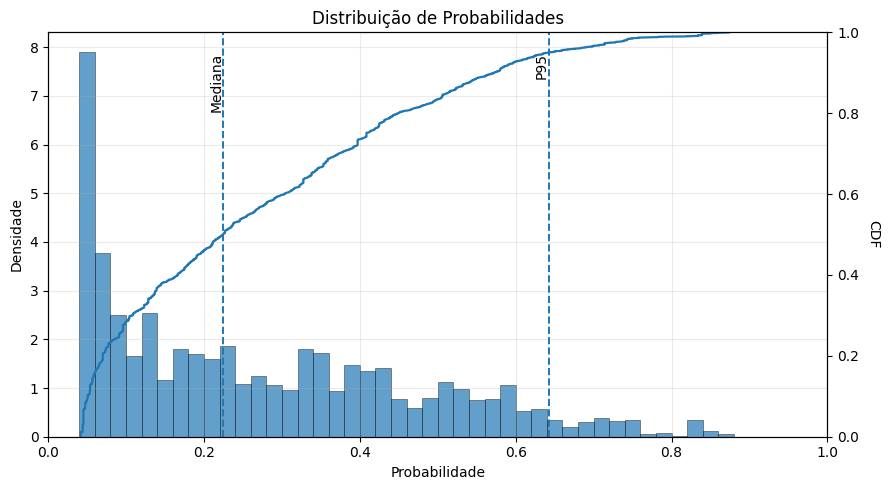

In [25]:
# 1) série limpa (probabilidades costumam estar em [0,1])
p = df_geral['prob'].dropna().clip(0, 1).values

# 2) bins fixos (iguais) — bons para comparar e evitar "denteado"
bins = np.linspace(0, 1, 51)  # 50 bins de 0.02

fig, ax = plt.subplots(figsize=(9, 5))

# 3) histograma como densidade (forma fica mais clara em desbalanceios)
ax.hist(p, bins=bins, density=True, alpha=0.7, edgecolor='k', linewidth=0.4)

# 4) (opcional) CDF no eixo secundário — ótimo para escolher cortes
ax2 = ax.twinx()
p_sorted = np.sort(p)
cdf = np.arange(1, len(p_sorted)+1) / len(p_sorted)
ax2.plot(p_sorted, cdf, linewidth=1.6)
ax2.set_ylabel('CDF', rotation=270, labelpad=15)
ax2.set_ylim(0, 1)

# 5) linhas-guia: mediana e P95 (ajuste quantis conforme seu uso)
q50, q95 = np.quantile(p, [0.50, 0.95])
for q, lab in [(q50, 'Mediana'), (q95, 'P95')]:
    ax.axvline(q, ls='--', lw=1.4)
    ax.text(q, ax.get_ylim()[1]*0.95, lab, rotation=90, va='top', ha='right')

ax.set_title('Distribuição de Probabilidades')
ax.set_xlabel('Probabilidade')
ax.set_ylabel('Densidade')
ax.set_xlim(0, 1)
ax.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

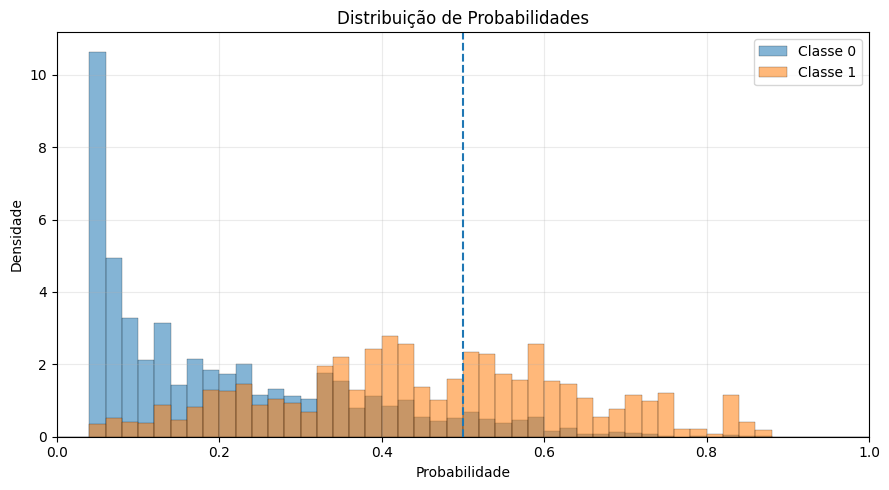

In [24]:
# separa as séries
neg = df_geral.loc[df_geral[alvo] == 0, 'prob'].values
pos = df_geral.loc[df_geral[alvo] == 1, 'prob'].values

# mesmos bins p/ ambos (probabilidades em [0,1])
bins = np.linspace(0, 1, 51)  # 50 bins iguais

fig, ax = plt.subplots(figsize=(9,5))

ax.hist(neg, bins=bins, density=True, alpha=0.55, edgecolor='k', linewidth=0.3,
        label='Classe 0')
ax.hist(pos, bins=bins, density=True, alpha=0.55, edgecolor='k', linewidth=0.3,
        label='Classe 1')

# (opcional) linha de threshold
thr = 0.5
ax.axvline(thr, linestyle='--', linewidth=1.5)

ax.set_title('Distribuição de Probabilidades')
ax.set_xlabel('Probabilidade')
ax.set_ylabel('Densidade')
ax.set_xlim(0, 1)
ax.grid(True, alpha=0.25)
ax.legend()
plt.tight_layout()
plt.show()